## Past Future correlation Momentum Trading Strategy
If we find that the correlation coefficient between a past return and future return is high and p-value is small [<0.05], proceed to see if its profitable
This strategy is derived from a paper by Moskowitz,Yao and Pedersen simply buy (sell) the future if it has a positive (negative) 12-month return, and hold the position for 1 month

In [12]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats 

    Look-back  Holding days  Correlation Coefficient  P-Value"
0         5.0           5.0                -0.067704  0.129799
1         5.0          10.0                -0.094235  0.136533
2         5.0          25.0                -0.045904  0.650184
3         5.0          60.0                -0.316071  0.044094
4         5.0         120.0                -0.321695  0.166627
5         5.0         180.0                -0.225934  0.457957
6         5.0         250.0                 0.468516  0.172009
7        10.0           5.0                -0.152727  0.015444
8        10.0          10.0                -0.159220  0.011703
9        10.0          25.0                -0.110805  0.272421
10       10.0          60.0                 0.014470  0.928450
11       10.0         120.0                 0.077311  0.745962
12       10.0         180.0                -0.019127  0.950548
13       10.0         250.0                 0.094686  0.794721
14       25.0           5.0                -0.079569  0

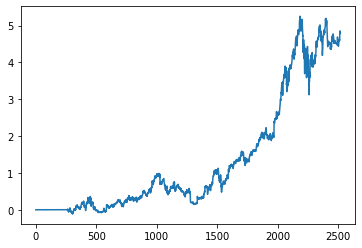

In [25]:
#Stock you want to analyze
df=web.DataReader('AMZN','yahoo','2010-01-01','2020-01-01' ) 
correlation_Opt(df)
cumret=strategy(df,250,25)
plt.plot(cumret)

In [17]:
def correlation_Opt(ts):
    ts.reset_index(drop=True,inplace=True)
    ts=ts['Adj Close']
    lookback=[5,10,25,60,120,180,250]
    holddays =[5,10,25,60,120,180,250]
    dfObj=pd.DataFrame(columns=['Look-back' , 'Holding days', 'Correlation Coefficient' , 'P-Value"'])
    for look in lookback:
        for hold in holddays:
           #Lag and Fut return
            ret_lag=(ts-ts.shift(look))/ts.shift(look)
            ret_fut=(ts.shift(-hold)-ts)/ts
            #Remove row with nan values
            df=pd.concat([ret_lag,ret_fut],axis=1)
            df.columns=['lag','fut']
            df.dropna(inplace=True)
            df.reset_index(drop=True,inplace=True)
            ret_lag=df['lag']
            ret_fut=df['fut']
            #Remove overlapping data 
            if (look>=hold):
                indepSet=np.arange(0,len(ret_lag)+1,look)
            else:
                indepSet=np.arange(0,len(ret_lag)+1,hold)
            
            ret_lag=ret_lag[indepSet]
            ret_fut=ret_fut[indepSet]
            cor,p_val=stats.pearsonr(ret_lag,ret_fut)
            dfObj = dfObj.append(pd.Series([look, hold, cor, p_val], index=dfObj.columns ), ignore_index=True)
    print (dfObj)


In [23]:
def strategy(ts,lookback,holddays):
    #ts.reset_index(inplace=True,drop=True)

    longs= ts['Adj Close'] > ts['Adj Close'].shift(lookback)
    shorts= ts['Adj Close'] < ts['Adj Close'].shift(lookback)
    
    ts['pos']=0
    
    positions = pd.DataFrame().reindex_like(longs.to_frame())
    positions = positions.fillna(0)
    #lag the long signal according to our holding period
    for h in range(holddays):
        long_lag=longs.shift(h).fillna(False)
        short_lag=shorts.shift(h).fillna(False)
                                       
        df.loc[long_lag,'pos']+=1
        df.loc[short_lag,'pos']-=1    
        ret=(df['pos'].shift(1)*(df['Adj Close']-df['Adj Close'].shift(1)) / df.Close.shift(1)) / holddays
        cumret=np.cumprod(1+ret)-1
    print ('-'*65)
    print ('Trading Statistics: ')
    print ('APR:', (((np.prod(1.+ret))**(252./len(ret)))-1)*100)
    print ('Sharpe:', np.sqrt(252.)*np.mean(ret)/np.std(ret)) 
    return cumret

